In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [4]:
df = pd.read_csv('HW_task/FEML/230421_Feature Selection/kobe.csv')

In [5]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [18]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [38]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [19]:
# проверяю наличие пустых строк в target

print('Для shot_made_flag пустых строк -  {}'.format( len( df[ pd.isnull( df['shot_made_flag'] ) ] ) ))
print('Всего строк                     -  {}'.format( len( df ) ))

Для shot_made_flag пустых строк -  5000
Всего строк                     -  30697


In [20]:
# удаляю пустые строки в target

data = df.dropna(subset = ['shot_made_flag']).reset_index()
data

,index,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
1,2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
2,3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
3,4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
4,5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,30691,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30692
25693,30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
25694,30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
25695,30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


In [21]:
# проверяю наличие пустых строк в target

print('Для shot_made_flag пустых строк -  {}'.format( len( data[ pd.isnull( data['shot_made_flag'] ) ] ) ))
print('Всего строк                     -  {}'.format( len( data ) ))

Для shot_made_flag пустых строк -  0
Всего строк                     -  25697


In [24]:
# выполняю преобразование в читабельный формат

data['new_game_date'] = pd.to_datetime(data['game_date'])
data['new_game_date']

0       2000-10-31
1       2000-10-31
2       2000-10-31
3       2000-10-31
4       2000-10-31
           ...    
25692   2000-06-19
25693   2000-06-19
25694   2000-06-19
25695   2000-06-19
25696   2000-06-19
Name: new_game_date, Length: 25697, dtype: datetime64[ns]

In [28]:
# добавляю переменные

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining'] + data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining']) + (60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

In [29]:
# проверяю координаты

data['coord'] = data['lat'].astype(str) + ', ' + data['lon'].astype(str)
data.coord.value_counts()

34.0443, -118.2698    4321
34.0433, -118.2698      16
34.0443, -118.2708       9
34.0433, -118.2688       8
34.0433, -118.2518       7
                      ... 
33.8783, -118.1318       1
34.0273, -118.3488       1
34.0333, -118.2938       1
33.9303, -118.1068       1
33.8983, -118.0588       1
Name: coord, Length: 17892, dtype: int64

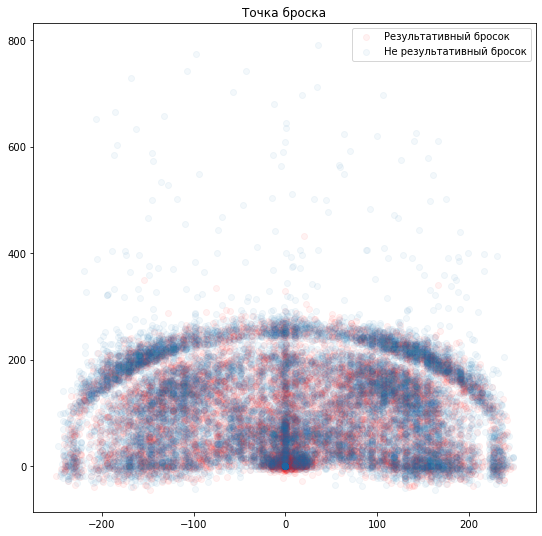

In [31]:
# смотрю разброс

rez = data[data['shot_made_flag'] == 1]
nrez = data[data['shot_made_flag'] == 0]
alpha = 0.05
plt.figure(figsize=(9, 9))
plt.scatter(rez.loc_x, rez.loc_y,color='red',  alpha=alpha, label = 'Результативный бросок')
plt.scatter(nrez.loc_x, nrez.loc_y,  alpha = alpha, label = 'Не результативный бросок')
plt.title('Точка броска')
plt.legend()

In [32]:
# беру в тест более поздние броски

def split_train_test(data, test_ratio):
    test_count = round(len(data) * test_ratio)
    train_count = len(data) - test_count
    return data.sort_values(by = ['new_game_date', 'secondsFromGameStart'], ascending=False).tail(train_count).reset_index(), \
           data.sort_values(by = ['new_game_date', 'secondsFromGameStart'], ascending=False).head(test_count).reset_index()

In [33]:
train_data, test_data = split_train_test(data, 0.2)
len(train_data), len(test_data)

(20558, 5139)

In [34]:
# разделяю признаки на числовые и категориальные оставляя на мой взгляд необходимые

num_columns = ['loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs', 'seconds_remaining', 'shot_distance',
               'secondsFromPeriodEnd', 'secondsFromPeriodStart', 'secondsFromGameStart']
cat_columns = ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
               'opponent']

In [35]:
# получаю список значений для всех категорийных

def get_cat_categories(df, cat_columns):
    categories = []
    for column in cat_columns:
        categories.append(list(df[column].unique()))    
    return categories

In [36]:
categories = get_cat_categories(data, cat_columns)
categories

[['Jump Shot',
  'Driving Dunk Shot',
  'Layup Shot',
  'Running Jump Shot',
  'Reverse Dunk Shot',
  'Slam Dunk Shot',
  'Driving Layup Shot',
  'Turnaround Jump Shot',
  'Reverse Layup Shot',
  'Tip Shot',
  'Running Hook Shot',
  'Alley Oop Dunk Shot',
  'Dunk Shot',
  'Alley Oop Layup shot',
  'Running Dunk Shot',
  'Driving Finger Roll Shot',
  'Running Layup Shot',
  'Finger Roll Shot',
  'Fadeaway Jump Shot',
  'Follow Up Dunk Shot',
  'Hook Shot',
  'Turnaround Hook Shot',
  'Jump Hook Shot',
  'Running Finger Roll Shot',
  'Jump Bank Shot',
  'Turnaround Finger Roll Shot',
  'Hook Bank Shot',
  'Driving Hook Shot',
  'Running Tip Shot',
  'Running Reverse Layup Shot',
  'Driving Finger Roll Layup Shot',
  'Fadeaway Bank shot',
  'Pullup Jump shot',
  'Finger Roll Layup Shot',
  'Turnaround Fadeaway shot',
  'Driving Reverse Layup Shot',
  'Driving Slam Dunk Shot',
  'Step Back Jump shot',
  'Turnaround Bank shot',
  'Reverse Slam Dunk Shot',
  'Floating Jump shot',
  'Putback 

In [40]:
# использую OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories = categories), cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    sparse_threshold = 0,
    remainder = 'drop'
)

In [41]:
def get_feature_names(column_transformer, df):
    feature_names = []
    for _, tr, columns in column_transformer.transformers:
        if type(tr).__name__ == 'OneHotEncoder':
            tr.fit(df[columns]) 
            feature_names.extend(list(tr.get_feature_names(columns)))
        elif type(tr).__name__ == 'StandardScaler':
            feature_names.extend(columns)
        else:
            raise RuntimeError(f'Unknown class: {type(tr).__name__}, plrase update function')
    return feature_names

In [42]:
feature_names = get_feature_names(preprocessor, train_data)
feature_names

['action_type_Jump Shot',
 'action_type_Driving Dunk Shot',
 'action_type_Layup Shot',
 'action_type_Running Jump Shot',
 'action_type_Reverse Dunk Shot',
 'action_type_Slam Dunk Shot',
 'action_type_Driving Layup Shot',
 'action_type_Turnaround Jump Shot',
 'action_type_Reverse Layup Shot',
 'action_type_Tip Shot',
 'action_type_Running Hook Shot',
 'action_type_Alley Oop Dunk Shot',
 'action_type_Dunk Shot',
 'action_type_Alley Oop Layup shot',
 'action_type_Running Dunk Shot',
 'action_type_Driving Finger Roll Shot',
 'action_type_Running Layup Shot',
 'action_type_Finger Roll Shot',
 'action_type_Fadeaway Jump Shot',
 'action_type_Follow Up Dunk Shot',
 'action_type_Hook Shot',
 'action_type_Turnaround Hook Shot',
 'action_type_Jump Hook Shot',
 'action_type_Running Finger Roll Shot',
 'action_type_Jump Bank Shot',
 'action_type_Turnaround Finger Roll Shot',
 'action_type_Hook Bank Shot',
 'action_type_Driving Hook Shot',
 'action_type_Running Tip Shot',
 'action_type_Running Rever

In [43]:
# количество признаков

len(feature_names)

124

In [45]:
# линейная регрессия
X = preprocessor.fit_transform(data)
y = np.array(data['shot_made_flag'])

In [46]:
clf_lin = LinearRegression()

In [47]:
clf_lin.fit(X, y)

LinearRegression()

In [48]:
y_pred_lin = clf_lin.predict(X)

In [49]:
lin_mse = mean_squared_error(y, y_pred_lin)
lin_rmse = np.sqrt(lin_mse)

In [51]:
print(f'RMSE     : {lin_rmse}')
print(f'Intercept: {clf_lin.intercept_}')
print(f'R^2      : {clf_lin.score(X, y)}')
print(f'RSS      : {sum((y_pred_lin - y) ** 2)}')

RMSE     : 0.4584924444657156
Intercept: -1000221611263.8397
R^2      : 0.14927494906437888
RSS      : 5401.903119981289


In [52]:
# Lasso

clf_lasso = Lasso()
clf_lasso.fit(X, y)

Lasso()

In [53]:
y_pred_lasso = clf_lasso.predict(X)
lasso_mse = mean_squared_error(y, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)

In [54]:
print(f'RMSE     : {lasso_rmse}')
print(f'Intercept: {clf_lasso.intercept_}')
print(f'R^2      : {clf_lasso.score(X, y)}')
print(f'RSS      : {sum((y_pred_lasso - y) ** 2)}')

RMSE     : 0.49709291421222224
Intercept: 0.44616103047048294
R^2      : 0.0
RSS      : 6349.763785655984


In [55]:
# Ridge

clf_ridge = Ridge()
clf_ridge.fit(X, y)

Ridge()

In [56]:
y_pred_ridge = clf_ridge.predict(X)
ridge_mse = mean_squared_error(y, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)

In [57]:
print(f'RMSE     : {ridge_rmse}')
print(f'Intercept: {clf_ridge.intercept_}')
print(f'R^2      : {clf_ridge.score(X, y)}')
print(f'RSS      : {sum((y_pred_ridge - y) ** 2)}')

RMSE     : 0.45825931606058046
Intercept: 0.6237396602657765
R^2      : 0.15013986082043074
RSS      : 5396.411134634908


In [58]:
# коэффициенты модели


df_coef = pd.DataFrame()
df_coef['Features'] = pd.Series(feature_names)
df_coef['LinearRegression'] = clf_lin.coef_
df_coef['Lasso'] = clf_lasso.coef_
df_coef['Ridge'] = clf_ridge.coef_

In [59]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)  
df_coef

,Features,LinearRegression,Lasso,Ridge
0,action_type_Jump Shot,1.508077e+11,-0.0,-0.341644
1,action_type_Driving Dunk Shot,3.923191e+11,0.0,0.105976
2,action_type_Layup Shot,5.982978e+11,-0.0,-0.281306
3,action_type_Running Jump Shot,1.508077e+11,0.0,0.105347
4,action_type_Reverse Dunk Shot,3.923191e+11,0.0,0.044793
...,...,...,...,...
119,seconds_remaining,-1.439638e+11,0.0,0.011746
120,shot_distance,1.483154e-02,-0.0,0.014057
121,secondsFromPeriodEnd,9.329026e+11,0.0,0.000823
122,secondsFromPeriodStart,-7.784820e+11,-0.0,-0.000823


Итог:  
Ridge регрессия более актуальна из трех.  
Знак перед коэффициентом можно трактовать как полезность признака:  
+ способствует результативному броску(попаданию)  
- способствует промаху

In [60]:
# пробую обучить на части данных и проверить на тестовых

X_train = preprocessor.fit_transform(train_data)
y_train = np.array(train_data['shot_made_flag'])

In [61]:
X_test = preprocessor.fit_transform(test_data)
y_test = np.array(test_data['shot_made_flag'])

In [62]:
# LinearRegression

clf_lin_test = LinearRegression()
clf_lin_test.fit(X_train, y_train)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_lin_train = clf_lin.predict(X_train)
lin_mse_test = mean_squared_error(y_test, y_pred_lin_test)
lin_rmse_test = np.sqrt(lin_mse_test)
lin_roc_auc_test = roc_auc_score(y_test, y_pred_lin_test)
lin_roc_auc_train = roc_auc_score(y_train, y_pred_lin_train)

In [63]:
print(f'RMSE         : {lin_rmse_test}')
print(f'Intercept    : {clf_lin_test.intercept_}')
print(f'R^2          : {clf_lin_test.score(X_test, y_test)}')
print(f'RSS          : {sum((y_pred_lin_test - y_test) ** 2)}')
print(f'ROC AUC test : {lin_roc_auc_test}')
print(f'ROC AUC train: {lin_roc_auc_train}')

RMSE         : 7556817586.847017
Intercept    : 205433353910.50516
R^2          : -1.5403132213301795e+22
RSS          : 2.9346512359808418e+23
ROC AUC test : 0.5170834287066752
ROC AUC train: 0.48036599077165376


In [64]:
lin_fpr_train, lin_tpr_train, _ = roc_curve(y_train, y_pred_lin_train)
lin_fpr_test, lin_tpr_test, _ = roc_curve(y_test, y_pred_lin_test)    

In [65]:
def plt_roc_auc(title, fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC {roc_auc_train}')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC {roc_auc_test}')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

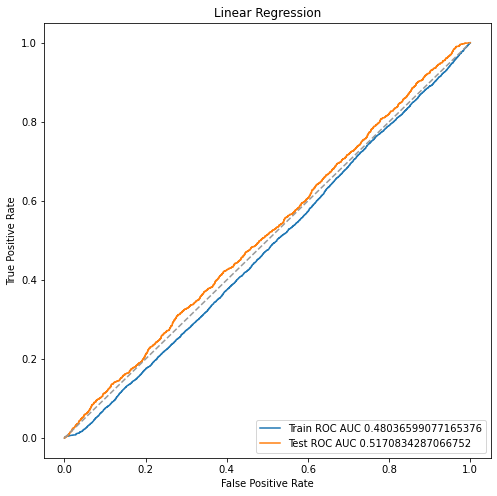

In [66]:
plt_roc_auc('Linear Regression', lin_fpr_train, lin_tpr_train, lin_roc_auc_train, lin_fpr_test, lin_tpr_test, lin_roc_auc_test)

In [67]:
# lasso

clf_lasso_test = Lasso()
clf_lasso_test.fit(X_train, y_train)
y_pred_lasso_train = clf_lasso_test.predict(X_train)
y_pred_lasso_test = clf_lasso_test.predict(X_test)
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso_test)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_roc_auc_train = roc_auc_score(y_test, y_pred_lasso_test)
lasso_roc_auc_test = roc_auc_score(y_test, y_pred_lasso_test)

In [68]:

print(f'RMSE         : {lasso_rmse_test}')
print(f'Intercept    : {clf_lasso_test.intercept_}')
print(f'R^2          : {clf_lasso_test.score(X_test, y_test)}')
print(f'RSS          : {sum((y_pred_lasso_test - y_test) ** 2)}')
print(f'ROC AUC train: {lasso_roc_auc_train}')
print(f'ROC AUC test : {lasso_roc_auc_test}')

RMSE         : 0.4944384817099362
Intercept    : 0.4533514933359276
R^2          : -0.00531617724269462
RSS          : 1256.3283092732638
ROC AUC train: 0.5
ROC AUC test : 0.5


In [69]:
lasso_fpr_train, lasso_tpr_train, _ = roc_curve(y_train, y_pred_lasso_train)
lasso_fpr_test, lasso_tpr_test, _ = roc_curve(y_test, y_pred_lasso_test)

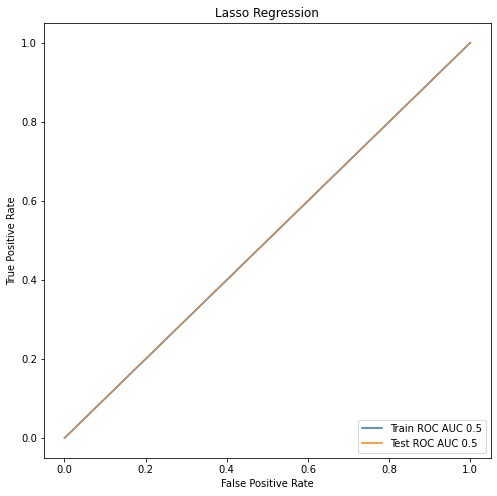

In [70]:
plt_roc_auc('Lasso Regression', lasso_fpr_train, lasso_tpr_train, lasso_roc_auc_train, lasso_fpr_test, lasso_tpr_test, lasso_roc_auc_test)

In [71]:
# Ridge

clf_ridge_test = Ridge()
clf_ridge_test.fit(X_train, y_train)
y_pred_ridge_train = clf_ridge_test.predict(X_train)
y_pred_ridge_test = clf_ridge_test.predict(X_test)
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge_test)
ridge_rmse_test = np.sqrt(ridge_mse_test)
ridge_roc_auc_train = roc_auc_score(y_train, y_pred_ridge_train)
ridge_roc_auc_test = roc_auc_score(y_test, y_pred_ridge_test)

In [72]:
print(f'RMSE         : {ridge_rmse_test}')
print(f'Intercept    : {clf_ridge_test.intercept_}')
print(f'R^2          : {clf_ridge_test.score(X_test, y_test)}')
print(f'RSS          : {sum((y_pred_ridge_test - y_test) ** 2)}')
print(f'ROC AUC train: {ridge_roc_auc_train}')
print(f'ROC AUC test : {ridge_roc_auc_test}')

RMSE         : 0.46966379220534654
Intercept    : 0.640553485954905
R^2          : 0.0929059804615936
RSS          : 1133.5815753450447
ROC AUC train: 0.7049089128546845
ROC AUC test : 0.6799659925912431


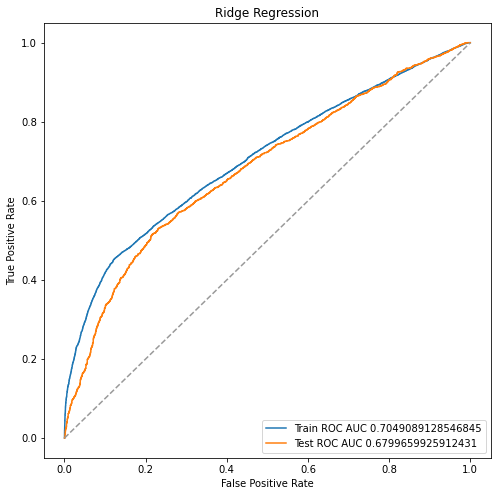

In [73]:
ridge_fpr_train, ridge_tpr_train, _ = roc_curve(y_train, y_pred_ridge_train)
ridge_fpr_test, ridge_tpr_test, _ = roc_curve(y_test, y_pred_ridge_test)
plt_roc_auc('Ridge Regression', ridge_fpr_train, ridge_tpr_train, ridge_roc_auc_train, ridge_fpr_test, ridge_tpr_test, ridge_roc_auc_test)

In [76]:
# PCA

pca = PCA(n_components = len(feature_names))
pca.fit(X)

PCA(n_components=124)

In [79]:
for i in range(1, 18):
    print(f'components: {i}, explained variance ratio: {sum(pca.explained_variance_ratio_[:i])}')

components: 1, explained variance ratio: 0.2270628388735405
components: 2, explained variance ratio: 0.4123670291315251
components: 3, explained variance ratio: 0.5391960907166219
components: 4, explained variance ratio: 0.6173954231331533
components: 5, explained variance ratio: 0.6870422663885023
components: 6, explained variance ratio: 0.755496101297458
components: 7, explained variance ratio: 0.8125804981802267
components: 8, explained variance ratio: 0.8392460120361414
components: 9, explained variance ratio: 0.8609983489769903
components: 10, explained variance ratio: 0.8726974482818619
components: 11, explained variance ratio: 0.8823281352231225
components: 12, explained variance ratio: 0.8901482715088271
components: 13, explained variance ratio: 0.8964750631805807
components: 14, explained variance ratio: 0.9023579067615678
components: 15, explained variance ratio: 0.907314167325919
components: 16, explained variance ratio: 0.9116009792700233
components: 17, explained variance 